##### A complex, multidisciplinary, and heterogeneous numerical model can be brken down into a series of chained (by passing variables from one to the next) smaller computations.

##### These smaller computations in OpenMDAO is performed inside a `Component` - Smallest unit of computational work. Every `Component` outputs it's own set of variables.



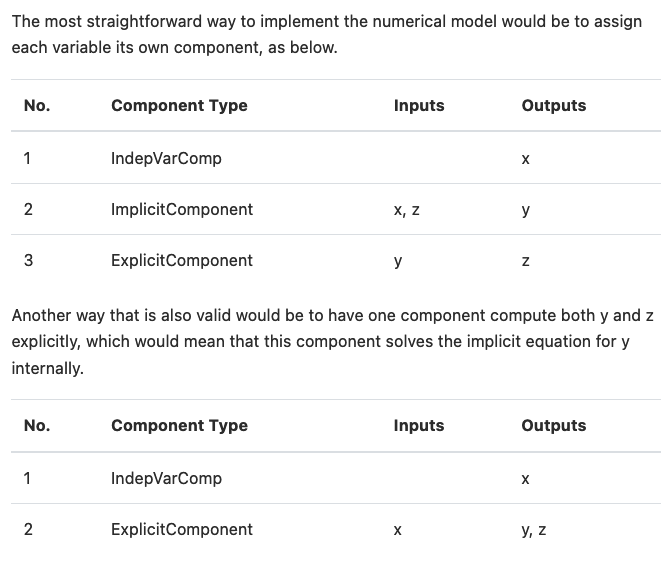

##### First way is recommended. Second way is more complicated because user must solve for `y` and `z` together, and also for  derivatives of `y` and `z` with `x`. This is non-trivial/significant.

##### OpenMDAO will automatically combine and assemble the derivatives from the components 2 and 3.

### Paraboloid - Single Discipline Model


In [8]:
import openmdao.api as om

# ExplicitComponent is contained in the openmdao.api module. This class is accessed through 'om.ExplicitComponent'.
class Paraboloid(om.ExplicitComponent):
    """
    Evaluates the equation f(x,y) = (x-3)^2 + xy + (y+4)^2 - 3.
    """

    def setup(self):
        self.add_input('x', val=0.0)
        self.add_input('y', val=0.0)

        self.add_output('f_xy', val=0.0)

    def setup_partials(self):
        # Finite difference all partials.
        self.declare_partials('*', '*', method='fd')

    def compute(self, inputs, outputs):
        """
        f(x,y) = (x-3)^2 + xy + (y+4)^2 - 3

        Minimum at: x = 6.6667; y = -7.3333
        """
        x = inputs['x']
        y = inputs['y']

        outputs['f_xy'] = (x - 3.0)**2 + x * y + (y + 4.0)**2 - 3.0


if __name__ == "__main__":

    model = om.Group()
    # parab_comp is an instance of the Paraboloid class
    model.add_subsystem('parab_comp', Paraboloid())

    # model Group with compoents, is passed to the constructor of the Problem class.
    prob = om.Problem(model)
    # call the setup() method on the problem.
    prob.setup()

    prob.set_val('parab_comp.x', 3.0)
    prob.set_val('parab_comp.y', -4.0)

    # to perform the computations
    prob.run_model()
    print(prob['parab_comp.f_xy'])

    # Trying twice with different input values
    prob.set_val('parab_comp.x', 5.0)
    prob.set_val('parab_comp.y', -2.0)

    prob.run_model()
    print(prob.get_val('parab_comp.f_xy'))

[-15.]
[-5.]


A class is a blueprint which you use to create objects. An object is an instance of a class - it's a concrete 'thing' that you made using a specific class. So, 'object' and 'instance' are the same thing, but the word 'instance' indicates the relationship of an object to its class.

This is easy to understand if you look at an example. For example, suppose you have a class House. Your own house is an object and is an instance of class House. Your sister's house is another object (another instance of class House).

// Class House describes what a house is
class House {
    // ...
}

// You can use class House to create objects (instances of class House)
House myHouse = new House();
House sistersHouse = new House();

The class House describes the concept of what a house is, and there are specific, concrete houses which are objects and instances of class House.

Note: This is exactly the same in Java as in all object oriented programming languages.


##### All OpenMDAO models are built from a hierarchy of `Group` instances which organize the components. In the above example, root group holds 1 component that is an instance/object to the `Paraboloid` class.

##### After defining hierarchy, the component is passed to the contructor of the `Problem` class. `setup()` method is called on the problem, which helps in getting data structures in place.

##### `run_model()` is called to perform the computation.

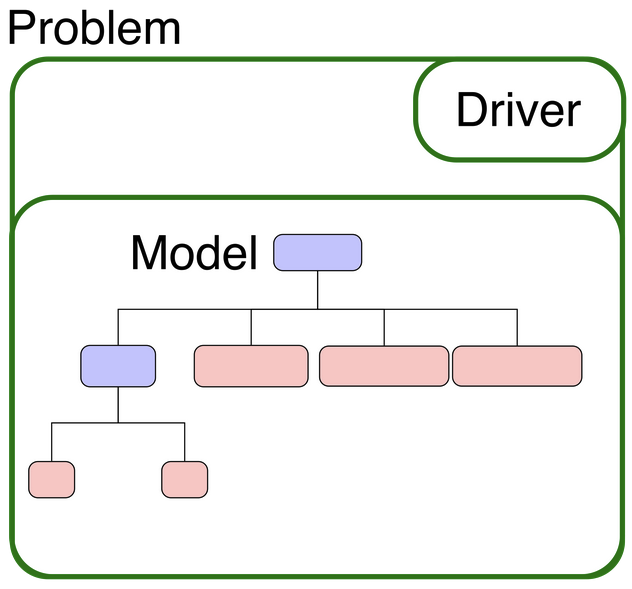

##### `Problem` class serves as a container for the model and the driver, and also has methods inside it to `run the model` and to `run the driver`. It is also an interface for setting and geting variable values.

##### Every `Problem` has a single driver associated with it, and has a single model in it.

In [9]:
import openmdao.api as om

# ExplicitComponent is contained in the openmdao.api module. This class is accessed through 'om.ExplicitComponent'.
class Paraboloid(om.ExplicitComponent):
    """
    Evaluates the equation f(x,y) = (x-3)^2 + xy + (y+4)^2 - 3.
    """

    def setup(self):
        self.add_input('x', val=0.0)
        self.add_input('y', val=0.0)

        self.add_output('f_xy', val=0.0)

    def setup_partials(self):
        # Finite difference all partials.
        self.declare_partials('*', '*', method='fd')

    def compute(self, inputs, outputs):
        """
        f(x,y) = (x-3)^2 + xy + (y+4)^2 - 3

        Minimum at: x = 6.6667; y = -7.3333
        """
        x = inputs['x']
        y = inputs['y']

        outputs['f_xy'] = (x - 3.0)**2 + x * y + (y + 4.0)**2 - 3.0
        
# build the model
prob = om.Problem()
prob.model.add_subsystem('parab', Paraboloid(), promotes_inputs=['x', 'y'])

# define the component whose output will be constrained
prob.model.add_subsystem('const', om.ExecComp('g = x + y'), promotes_inputs=['x', 'y'])

# Design variables 'x' and 'y' span components, so we need to provide a common initial
# value for them.
prob.model.set_input_defaults('x', 3.0)
prob.model.set_input_defaults('y', -4.0)

# setup the optimization
prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'COBYLA'

prob.model.add_design_var('x', lower=-50, upper=50)
prob.model.add_design_var('y', lower=-50, upper=50)
prob.model.add_objective('parab.f_xy')

# to add the constraint to the model
prob.model.add_constraint('const.g', lower=0, upper=10.)

prob.setup()
prob.run_driver();


Optimization Complete
-----------------------------------

   Normal return from subroutine COBYLA

   NFVALS =   54   F =-2.700000E+01    MAXCV =-0.000000E+00
   X = 6.999999E+00  -6.999999E+00


In [10]:
# minimum value
print(prob.get_val('parab.f_xy'))

[-27.]


In [11]:
# location of the minimum
print(prob.get_val('x'))
print(prob.get_val('y'))

[6.99999912]
[-6.99999912]


#### Now we have added another another equation `x = -y = 7.0` through 'g = x + y' under `const` component.

In [12]:
! openmdao n2 OpenMDAO-basic-userguide-1.py

In [13]:
! openmdao n2 OpenMDAO-basic-userguide-2.py